In [1]:
import xarray as xr
import pandas as pd

from functions import plot_params
import numpy as np
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# READ IN THE OBSERVATIONS

# read in the slocum data

sl = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/slocum/slocum_L2_20231110.nc')
sl = sl.load()

sl_sst = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/slocum/slocum_sst_mean_10m_20231110.nc')
sl_sst = sl_sst.load()

# sl_grid = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/slocum/slocum_gridded_20240227.nc')
# sl_grid = sl_grid.load()

# read the wave glider and the mixing data sets

ep = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/slocum/slocum_eps_ds_processed_era5_23Sep2022.nc')
wg = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/waveglider/WG_era5_1h_processed_28Aug2022.nc')

xld = pd.read_csv('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/slocum/mixing_layer_xld.csv')

xld = xr.Dataset(data_vars=dict(
                                   xld = (['time'], xld.xld.values)),                   
                    coords=dict(
                                time = (['time'], xld.Date.values.astype('datetime64[ns]'))),                   
                    attrs=dict(
                               description="Processed Slocum glider XLD data."))

xld = xld.isel(time=xld.xld>0)


In [3]:
# sl_grid['longitude'] = (('time'), sl_grid.longitude.values)
# sl_grid['latitude'] = (('time'), sl_grid.latitude.values)

In [4]:
# GLIDER PROCESSING

# calculate conservative temperature and absolute salinity

import gsw

# Convert salinity from SP to SA and temperature from T to CT
sa = gsw.SA_from_SP(sl['salinity'].data, sl['pressure'].data, sl['longitude'].data, sl['latitude'].data)

ct = gsw.CT_from_t(sa, sl['temperature'].data, sl['pressure'].data)

sl['con_temp'] = (('time'), ct)
sl['abs_salt'] = (('time'), sa)

# Calculate seawater density using gsw
sl['density'] = gsw.rho(sl['abs_salt'].data, sl['con_temp'].data, sl['pressure'].data / 1013.25)

# grid the slocum data to 1m depth intervals

from scipy.interpolate import griddata

new_z = np.arange(0, 1001, 1)
time = np.array([], dtype='datetime64[ns]')

lat = np.array([])
lon = np.array([])

temp = np.ndarray([np.unique(sl.dive.data).size, new_z.size])
salt = np.ndarray([np.unique(sl.dive.data).size, new_z.size])
dens = np.ndarray([np.unique(sl.dive.data).size, new_z.size])

for i, d in enumerate(np.unique(sl.dive.data)):

    dive = sl.isel(time=sl.dive==d)

    temp[i] = griddata(dive.depth.data, dive.con_temp.data, new_z)
    salt[i] = griddata(dive.depth.data, dive.abs_salt.data, new_z)
    dens[i] = griddata(sorted(dive.depth.data), dive.density.data, new_z)
  
    time = np.append(time, dive.time.min())
    lon  = np.append(lon, np.nanmedian(dive.longitude.data))
    lat  = np.append(lat, np.nanmedian(dive.latitude.data))    

In [5]:
# CREATE AN XARRAY DATASET FOR THE SLOCUM DATA

# xarray dataset for slocum gridded data

sl_grid = xr.Dataset(
    {
        'temperature': (['depth', 'time'], temp.T),
        'salinity': (['depth', 'time'], salt.T),
        'density': (['depth', 'time'], dens.T),
        'latitude': (['time'], lat),
        'longitude': (['time'], lon),        
    },
    coords={
        'time': time,
        'depth': new_z
    }
)

# Optionally add attributes
sl_grid['temperature'].attrs['units'] = 'deg Celsius'
sl_grid['salinity'].attrs['units'] = 'g/kg'
sl_grid['density'].attrs['units'] = 'kg/m^3'
sl_grid['temperature'].attrs['long_name'] = 'Converative Temperature'
sl_grid['salinity'].attrs['long_name'] = 'Absolute Salinity'
sl_grid['density'].attrs['long_name'] = 'Seawater Density'

In [6]:
# determine the day of year variable for hte various datasets

import matplotlib.dates as mdates

day0=mdates.date2num(np.datetime64('2019-01-01 00:00:00'))

sl['DOY']=(('time'), mdates.date2num(sl.time)-day0)
sl_sst['DOY']=(('time'), mdates.date2num(sl_sst.time)-day0)
ep['DOY']=(('time'), mdates.date2num(ep.TIME)-day0)
xld['DOY']=(('time'), mdates.date2num(xld.time)-day0)
sl_grid['DOY']=(('time'), mdates.date2num(sl_grid.time)-day0)

In [7]:
# CALCULATE STRATIFICATION FROM THE GLIDER

g = 9.81

N2_T = np.ndarray([np.unique(sl.dive.data).size, new_z.size])
N2_S = np.ndarray([np.unique(sl.dive.data).size, new_z.size])

for i in range(sl_grid.time.size):

    dive = sl_grid.isel(time=i)

    alpha = gsw.alpha(dive['salinity'].data, dive['temperature'].data, dive['depth'].data)[1:]
    beta = gsw.beta(dive['salinity'].data, dive['temperature'].data, dive['depth'].data)[1:]

    N2_T[i] = np.append(-g*alpha*(dive['temperature'].diff(dim='depth')), np.nan)
    N2_S[i] = np.append( g*beta*(dive['salinity'].diff(dim='depth')), np.nan)

sl_grid['N2_T'] = (('depth', 'time'), N2_T.T)
sl_grid['N2_S'] = (('depth', 'time'), N2_S.T)

sl_grid['N2'] = (('depth', 'time'), N2_S.T + N2_T.T)

In [8]:
# calculate the mixed layer depth

from functions.calc_mld import calc_mld

mld = calc_mld(sl_grid.temperature.T.data, sl_grid.depth.data, den_lim=0.2)

sl_grid['mld_t'] = (('time'), mld)

In [9]:
# cut the slocum data to meet the data length of the mixing layer depth

sl_grid = sl_grid.sel(time=slice(xld.time[0].data, xld.time[-1].data))
sl_sst = sl_sst.sel(time=slice(xld.time[0].data, xld.time[-1].data))

sl_sst_6h = sl_sst.resample(time='6H').mean()
sl_sst_1d = sl_sst.resample(time='1D').mean()

xld_6h = xld.resample(time='6H').mean()

In [10]:
# LOAD THE ERA5 DATASET 

ds_era5_vars = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/ERA5/ds_era5_vars.nc').load()
ds_era5_flux = xr.open_dataset('/Users/xduplm/Google Drive/My Drive/data/duplessis-storms-paper/ERA5/ds_era5_flux.nc').load()

print('merging')

ds_era5_atl = xr.merge([ds_era5_vars, ds_era5_flux])

merging


In [11]:
# PROCESS ERA5 

ds_era5_atl['sp'] = (('time', 'latitude', 'longitude'), ds_era5_atl['sp'].data/100)

ds_era5_atl['wnd'] = (('time', 'latitude', 'longitude'), np.sqrt(ds_era5_atl['u10']**2 + ds_era5_atl['v10']**2).data)

ds_era5_site = ds_era5_atl.sel(longitude=0, latitude=-54)

import matplotlib.dates as mdates

ds_era5_site['DOY']=(('time'), mdates.date2num(ds_era5_site.time)-day0)

ds_era5_site = ds_era5_site.sel(time=slice(xld.time.data[0], xld.time.data[-1]))

ds_era5_site['qnet'] = (('time'), ds_era5_site['sshf'].data + ds_era5_site['slhf'].data + ds_era5_site['str'].data + ds_era5_site['ssr'].data)

ds_era5_site['sthf'] = (('time'), ds_era5_site.sshf.data + ds_era5_site.slhf.data)

import functions.dewpoint_to_rh as dp2rh

ds_era5_site = dp2rh.convert_dp_to_rh(ds_era5_site)

ds_era5_site['dt'] = (('time'), ds_era5_site['t2m'].data - ds_era5_site['sst'].data)

In [12]:
# STORM IDENTIFICATION

# Identify storms by taking the wind speed as 10 m/s or larger for 8 hours or more

storm_locs = np.arange(ds_era5_site.time.size)[ds_era5_site.wnd>10]  # Find the indices where wind speed is greater than 10 m/s

# Finding consecutive groups

consecutive_storm_locs = np.split(storm_locs, np.where(np.diff(storm_locs) != 1)[0] + 1)  # Split the indices into groups where consecutive indices differ by 1

# Merging groups with a difference of two or less indices

merged_groups = [consecutive_storm_locs[0]]  # Initialize with the first group

for group in consecutive_storm_locs[1:]:
    if group[0] - merged_groups[-1][-1] <= 8:  # If the difference between the first index of the current group and the last index of the last group is less than or equal to 8
        merged_groups[-1] = np.concatenate((merged_groups[-1], group))  # Merge the current group with the last group
    else:
        merged_groups.append(group)  # Otherwise, add the current group as a new group

merged_storms = []

for i in range(len(merged_groups)):
    if len(merged_groups[i]) > 12:  # If the length of the group is greater than 12
        merged_storms.append(merged_groups[i])  # Add the group to the list of merged storms

# Append the indices of the merged storms to the storms_idx array

storms_idx = np.array([])

for s in range(len(merged_storms)):
    storms_idx = np.append(storms_idx, merged_storms[s])  

# Initialize an array of zeros with the same size as the time dimension

storms = np.zeros(ds_era5_site.time.size)  

# Set the indices corresponding to storms to 1

storms[storms_idx.astype(int)]=1  

# Add the storms array to the dataset as a new variable

ds_era5_site['storms'] = (('time'), storms)  

ds_era5_site['storms'].attrs['long_name'] = 'Boolean value for the presence of storm conditions (>10 m/s winds for 8 consecutive hours). 0 = non storm, 1 = storm.'  # Add a long_name attribute to the storms variable

ds_storms = ds_era5_site.isel(time=ds_era5_site.storms==1)  # Select the times when storms are present
ds_non_storms = ds_era5_site.isel(time=ds_era5_site.storms==0)  # Select the times when storms are not present


In [13]:
print('Storm hours:', ds_storms.time.size)
print('Non-storm hours:', ds_non_storms.time.size)

total_hours = ds_storms.time.size + ds_non_storms.time.size

print('Storm %:', 100*ds_storms.time.size/total_hours)

Storm hours: 940
Non-storm hours: 944
Storm %: 49.89384288747346


(array([6., 8., 2., 2., 0., 4., 1., 0., 4., 2., 0., 2., 0., 0., 1., 0., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]),
 array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
        0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ,
        1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65,
        1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15, 2.2 ,
        2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 , 2.75,
        2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15, 3.2 , 3.25, 3.3 ,
        3.35, 3.4 , 3.45, 

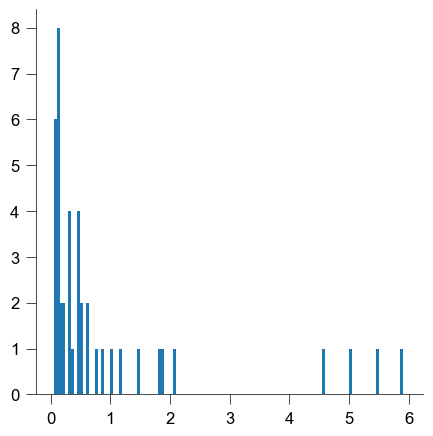

In [14]:
fig, ax = plt.subplots(figsize=(5,5))

ax.hist(np.diff(ds_storms.DOY), bins=np.arange(0.05, 6, 0.05))

In [15]:
np.mean(np.diff(ds_storms.DOY)[np.diff(ds_storms.DOY)>0.045]) * 24

22.395348837207273

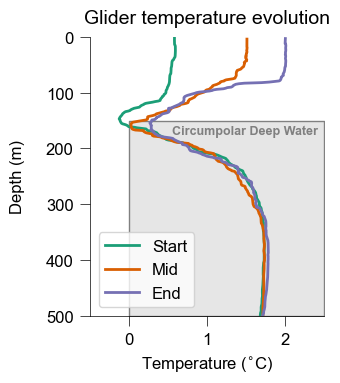

In [16]:
# PLOT BEGINNING, MID-POINT, AND END TEMP PROFILES

# PEDRO COMMENT: can you show temp profiles at beginning, mid point and end? 
# at the observation location the CDW temperature should be approx 2oC.  
# So the question is whether entrainment is cooling or warming?  
# also what is the role of salinity in N2?

# choosing colorblind friendly colors: https://colorbrewer2.org/#type=qualitative&scheme=Dark2&n=3
color1='#1b9e77'
color2='#d95f02'
color3='#7570b3'

fig, ax = plt.subplots(figsize=(3.5,4))

ax.plot(sl_grid.temperature.isel(time=5),   sl_grid.depth, c=color1, lw=2, label='Start')
ax.plot(sl_grid.temperature.isel(time=380), sl_grid.depth, c=color2, lw=2, label='Mid')
ax.plot(sl_grid.temperature.isel(time=760), sl_grid.depth, c=color3, lw=2, label='End')

ax.fill_betweenx(x1=0, x2=2.5, y=[150, 500], facecolor='0.9', edgecolor='0.5')

ax.text(0.55, 175, 'Circumpolar Deep Water', fontweight='bold', c='0.5', fontsize=9)

ax.invert_yaxis()
ax.legend()

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(500, 0)

ax.set_ylabel('Depth (m)', labelpad=15)
ax.set_xlabel('Temperature ($^{\circ}$C)')

ax.set_title('Glider temperature evolution', fontsize=14, pad=10)

fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/temp_profiles_start_mid_end.png', dpi=300)


In [17]:
# CHANGE THE DATES FOR THE WAVE GLIDER AND ERA5 WINDS

wg = wg.sel(date=slice(wg.date[3], wg.date[-1]))
u10_era5 = ds_era5_site.sel(time=slice(wg.date[0], wg.date[-1]))

In [18]:
wg = wg.sel(dayofyear=slice(wg.dayofyear[3], wg.dayofyear[-1]))

idx = ~np.isnan(wg['WindSpeed_ms_10m'])

np.corrcoef(wg['WindSpeed_ms_10m'].data[idx], u10_era5.wnd.data[idx])[0,1]**2

np.mean(wg['WindSpeed_ms_10m'].data[idx] - u10_era5.wnd.data[idx])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


1.2256678994637882

In [19]:
# CALCULATE THE ENTRAINMENT TERM

In [20]:
# find the temperature difference between the MLD and 10 m below the MLD

depth = 5

dT = np.ndarray(sl_grid.mld_t.size)

for i, mld in enumerate(sl_grid.mld_t):

    try: 
        mld_int = mld.data.astype(int)

        mld_int = mld.data.astype(int) + depth

        t_mld = sl_grid.temperature[mld_int-5, i]
        t_mld_depth = sl_grid.temperature[mld_int+depth, i]

        dT[i] = t_mld - t_mld_depth

    except:
        dT[i] = np.nan

/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_59388/3618314227.py:10: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.astype(int)
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_59388/3618314227.py:12: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.astype(int) + depth
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_59388/3618314227.py:10: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.astype(int)
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_59388/3618314227.py:12: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.astype(int) + depth
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_59388/3618314227.py:10: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.astype(int)
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_59388/3618314227.py:12: RuntimeWarning: invalid value encountered in cast
  mld_int = mld.data.

In [21]:
# grid the mixed layer depth and delta temperature to 1 hour time steps

mld_1hr = griddata(sl_grid.DOY, sl_grid.mld_t, ds_era5_site.DOY) # grid the mld to 1 hour
dT_1hr = griddata(sl_grid.DOY, dT, ds_era5_site.DOY) # grid the temperature difference between the MLD and 10 m below the base to 1 hour

from scipy.ndimage import uniform_filter1d

# Apply a smoothing window on the MLD and dT
import glidertools as gt

mld_1hr_smooth = gt.cleaning.rolling_window(mld_1hr,np.nanmean,24)
dT_1hr_smooth = gt.cleaning.rolling_window(dT_1hr,np.nanmean,6)

dmld_dt = np.gradient(mld_1hr_smooth)/3600 # mld difference in meters per second
dmld_dt = np.append(np.array(0), np.diff(mld_1hr_smooth))/3600 # mld difference in meters per second


dmld_dt[dmld_dt<0]=0 # if the mld is shoaling, make the entrainment velocity zero


/Users/xduplm/opt/anaconda3/envs/storms_env/lib/python3.11/site-packages/glidertools/helpers.py:76: GliderToolsWarning: Primary input variable is not xr.DataArray data type - no metadata to pass on.
  warnings.warn(msg, category=GliderToolsWarning)


In [22]:
# entrainment term

entrainment_dT = (dT_1hr_smooth*dmld_dt)/mld_1hr_smooth

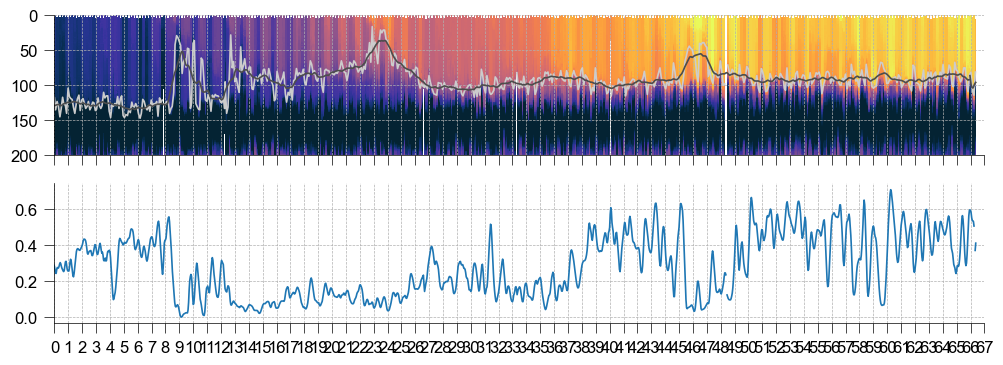

In [23]:
fig,ax=plt.subplots(2, figsize=(12,4), sharex=True)

img = ax[0].pcolormesh(sl_grid.DOY, sl_grid.depth, sl_grid.temperature, vmin=0.5, vmax=2.2, cmap=cmo.thermal)

ax[0].set_ylim(200,0)

ax[0].plot(sl_grid.DOY, sl_grid.mld_t, c='0.8')
ax[0].plot(ds_era5_site.DOY, mld_1hr_smooth, c='0.3')

# plt.colorbar(img)

for a in ax:

    a.xaxis.set_ticks(np.arange(-13, 68, 1))
    a.set_xlim(0,67)
    a.grid(lw=0.5, ls='--')

ax[1].plot(ds_era5_site.DOY, dT_1hr_smooth)

In [24]:
# CALCULATE THE HEAT FLUX PROJECTED SST

heat_flux_dT = ds_era5_site.qnet/(1027*4000*mld_1hr)


In [25]:
proj_sst_heat_flux = 3600*np.cumsum(heat_flux_dT)
proj_sst_entrainment = -3600*np.nancumsum(entrainment_dT)

proj_sst_net = proj_sst_heat_flux + proj_sst_entrainment

ds_era5_site['proj_sst_net'] = (('time'), proj_sst_net.data)

In [26]:
import functions.windstress as ws

# wg = xr.open_dataset('/home/mduplessis/data/waveglider/WG_era5_1h_processed_28Aug2022.nc')

wg['tau_obs']  = (('date'), ws.stress(wg.WindSpeed_ms_10m, z=10.0, drag='largepond', rho_air=1.22, Ta=wg.t2m_era5))
wg['tau_era5'] = (('date'), ws.stress(wg.wspeed_era5,      z=10.0, drag='largepond', rho_air=1.22, Ta=wg.t2m_era5))

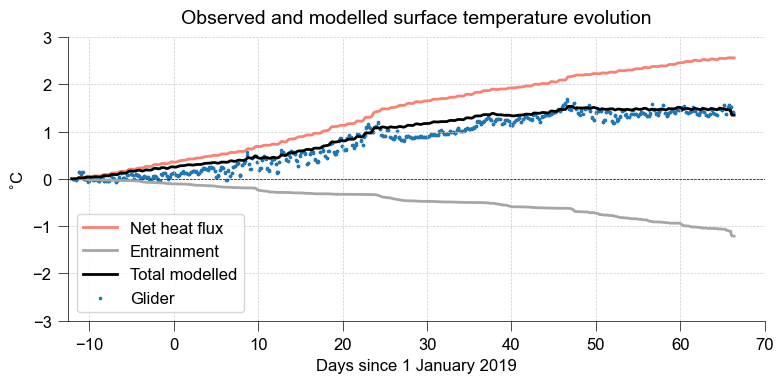

In [27]:
fig, ax = plt.subplots(figsize=(8,4))

ax.axhline(c='k', lw=0.5, ls='--')

# plot the individual terms
ax.plot(ds_era5_site.DOY, proj_sst_heat_flux, label='Net heat flux', lw=2, c='salmon')
ax.plot(ds_era5_site.DOY, proj_sst_entrainment, label='Entrainment', lw=2, c='0.65')

# plot the net modelled sst
ax.plot(ds_era5_site.DOY, ds_era5_site.proj_sst_net, label='Total modelled', lw=2, c='k')

# glider observations
ax.scatter(sl_sst.DOY, sl_sst.sst-0.6, s=10, marker='.', label='Glider')

ax.set_xlim(-12.5, 70)
ax.set_ylim(-3, 3)

ax.legend(loc=3)

ax.set_xlabel('Days since 1 January 2019')
ax.set_ylabel('$^{\circ}$C')

ax.grid(ls='--', c='0.8', lw=0.5)

ax.set_title('Observed and modelled surface temperature evolution', fontsize=14, pad=10)

fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/observed_modelled_temp_evo.png', dpi=600)

In [29]:
ds_era5_site_1D = ds_era5_site.resample(time='1D').mean()
ds_era5_site_1D = ds_era5_site_1D.isel(time=np.arange(ds_era5_site_1D.time.size)[1:])

In [35]:
ds_era5_site_1D

<xarray.Dataset>
Dimensions:       (time: 79)
Coordinates:
    latitude      float32 -54.0
    longitude     float32 0.0
  * time          (time) datetime64[ns] 2018-12-20 2018-12-21 ... 2019-03-08
Data variables: (12/19)
    u10           (time) float32 -2.671 10.34 4.782 11.33 ... 6.084 12.86 12.51
    v10           (time) float32 -0.4214 -7.475 4.176 ... 5.379 -2.057 6.534
    sst           (time) float32 274.2 274.1 274.2 274.1 ... 275.3 275.0 274.9
    skt           (time) float32 274.0 274.1 274.1 274.1 ... 275.2 275.2 275.0
    d2m           (time) float32 272.7 273.0 271.3 271.8 ... 270.2 273.7 273.3
    t2m           (time) float32 273.9 274.4 273.6 273.7 ... 274.7 275.6 275.4
    ...            ...
    qnet          (time) float32 153.1 160.9 48.86 168.5 ... 60.55 47.51 7.867
    sthf          (time) float32 -8.207 -8.647 -43.19 ... -56.41 -7.326 -17.29
    rh            (time) float32 91.18 90.44 84.97 86.89 ... 72.54 87.48 86.54
    dt            (time) float32 -0.3008 0.3067 -0.6413 ... -0.629 0.5148 0.4242
    storms        (time) float64 0.125 0.9167 0.5833 1.0 ... 0.5 0.25 0.9167 0.9
    proj_sst_net  (time) float64 0.008813 0.02798 0.0388 ... 1.476 1.466 1.356
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-21 19:42:14 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [41]:
np.corrcoef(sl_sst_1d.sst, ds_era5_site_1D.proj_sst_net)**2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


array([[1.        , 0.97788983],
       [0.97788983, 1.        ]])

In [52]:
for i in np.arange(0.4, 0.61, 0.01):

    print(np.sqrt((sl_sst_1d.sst-(ds_era5_site_1D.proj_sst_net+i))**2).mean().values)

0.104317066069533
0.09759782461214628
0.09106115106665452
0.08491610173604593
0.07936850582063948
0.07414008486620047
0.06938049229167541
0.06578909309792678
0.06359502047613651
0.06303076813523936
0.06350163247006226
0.0646559266407345
0.06670812800588348
0.06962919781603137
0.07346540137496951
0.07871844203387574
0.08493300754190161
0.09206388987053697
0.0994474626231975
0.10717374424230265
0.11540159234356849


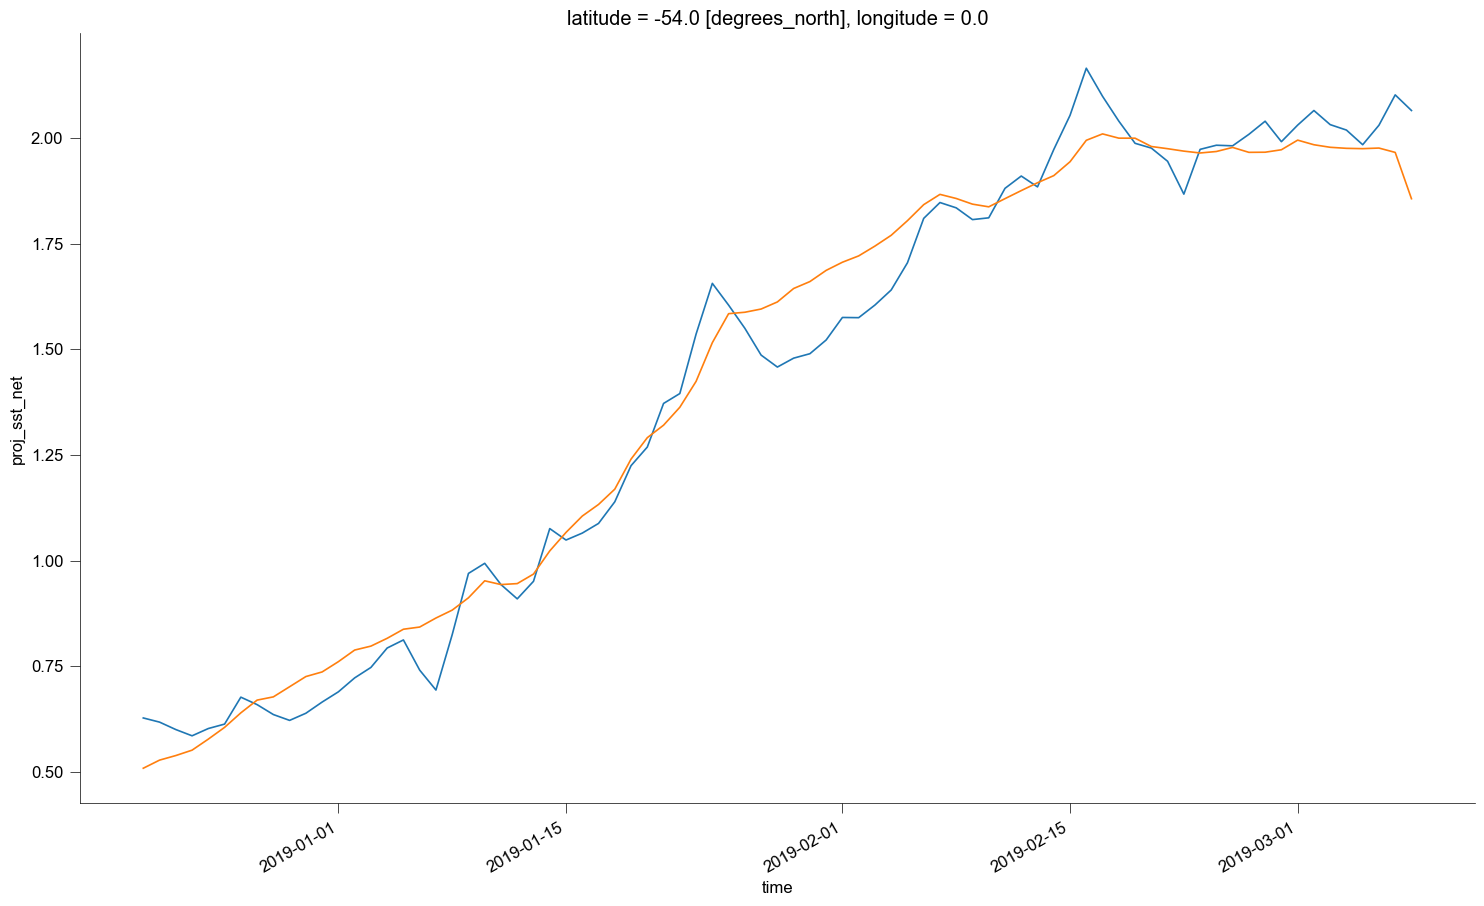

In [39]:
sl_sst_1d.sst.plot()
(ds_era5_site_1D.proj_sst_net+0.5).plot()

In [34]:
sl_sst_1d

<xarray.Dataset>
Dimensions:  (time: 79)
Coordinates:
  * time     (time) datetime64[ns] 2018-12-20 2018-12-21 ... 2019-03-08
Data variables:
    dive_no  (time) float64 89.0 94.5 99.75 105.2 ... 464.8 469.8 474.2 477.2
    sst      (time) float64 0.6277 0.6179 0.6003 0.5855 ... 2.03 2.102 2.065
    num_n    (time) float64 73.55 78.09 78.0 71.5 83.8 ... 84.2 88.4 96.5 76.5
    lat      (time) float64 -54.02 -54.01 -54.01 -54.0 ... -54.01 -54.01 -53.98
    lon      (time) float64 -0.008326 -0.006809 -0.01064 ... -0.00403 -0.004069
    DOY      (time) float64 -11.55 -10.51 -9.504 -8.526 ... 64.54 65.5 66.13

In [ ]:
# CALCULATE THE BUOYANCY FLUXES

g = -9.81
alpha = gsw.alpha(34, ds_era5_site.sst, p=0)
rho = 1027
cp = 4000

ds_era5_site['Bo'] = -(g*alpha*ds_era5_site.qnet)/(rho*cp)

ds_era5_site_1D = ds_era5_site.resample(time='1D').mean()

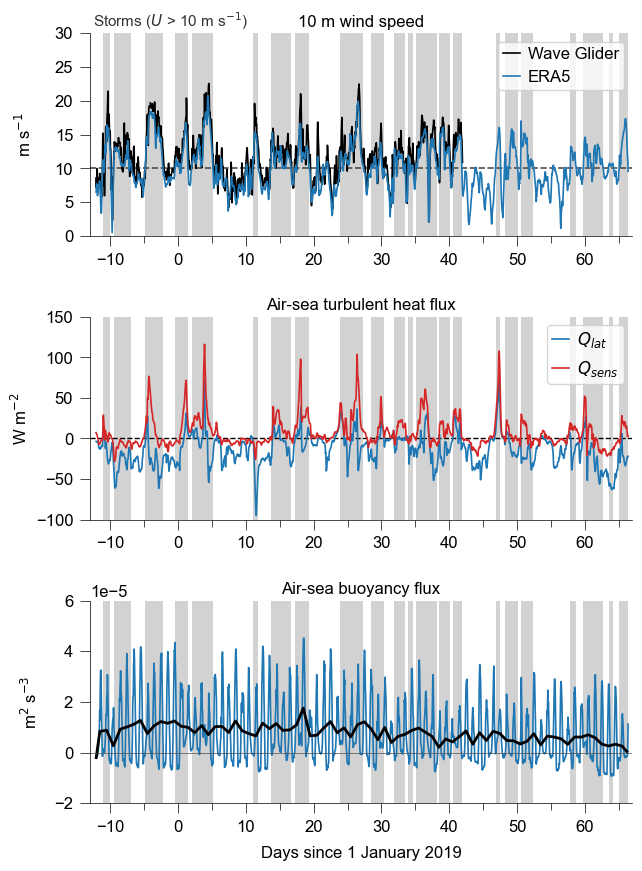

In [110]:
# PLOT THE OBSERVATIONAL SECTIONS FIRST PART

fig,ax=plt.subplots(3, figsize=(7,10))

fig.subplots_adjust(hspace=0.4)

ax[0].plot(wg['dayofyear'], wg['WindSpeed_ms_10m'], c='k', label='Wave Glider')

ax[0].plot(ds_era5_site.DOY, ds_era5_site.wnd, label='ERA5')
ax[0].axhline(10, c='0.3', ls='--', zorder=1)

ax[1].plot(ds_era5_site.DOY, ds_era5_site.slhf, label='$Q_{lat}$')
ax[1].plot(ds_era5_site.DOY, ds_era5_site.sshf, label='$Q_{sens}$', c='tab:red')

ax[2].plot(ds_era5_site.DOY, ds_era5_site.Bo)
ax[2].plot(ds_era5_site_1D.DOY, ds_era5_site_1D.Bo, c='k', lw=2)
ax[2].axhline(0, c='0.3', lw=0.5)

ax[0].set_ylim(0, 30)
ax[1].set_ylim(-100, 150)
ax[2].set_ylim(-2e-5, 6e-5)

for i, a in enumerate(ax):
    
    a.set_xlim(-13, 67)
    a.xaxis.set_ticks(np.arange(-10, 70, 10), minor=False)
    a.xaxis.set_ticks(np.arange(-10, 70, 5), minor=True)

    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

    for s in range(len(merged_storms)):

        start = merged_storms[s][0]
        end = merged_storms[s][-1]
        
        a.fill_betweenx(y=[-200, 1000], x1=ds_era5_site.DOY[start], x2=ds_era5_site.DOY[end], facecolor='0.65', alpha=0.5, zorder=0)        

ax[0].set_ylabel('m s$^{-1}$', labelpad=15)
ax[1].set_ylabel('W m$^{-2}$')
ax[2].set_ylabel('m$^2$ s$^{-3}$', labelpad=10)

ax[0].yaxis.set_ticks(np.arange(0, 35, 5))
ax[1].yaxis.set_ticks(np.arange(-100, 200, 50))

ax[1].axhline(0, c='k', lw=1, ls='--', zorder=0)

ax[0].legend(loc=1, bbox_to_anchor=(1, 1), handlelength=1, handletextpad=0.5, borderpad=0.3, fontsize=12, ncol=1, frameon=True)
ax[1].legend(loc=1, bbox_to_anchor=(1, 1), handlelength=1, handletextpad=0.5, borderpad=0.3, fontsize=12, ncol=1, frameon=True)

ax[2].set_xlabel('Days since 1 January 2019', labelpad=8)

ax[2].text(32, 230, '')

ax[0].text(-12.5, 31, 'Storms ($U$ > 10 m s$^{-1}$)', c='0.2', fontsize=11)

bbox_props = dict(boxstyle="round,pad=0.3", fc="0.95", ec="black", lw=1)

#ax[0].text(25, 27.5, '10m wind speed', ha="center", va="center", bbox=bbox_props)
#ax[1].text(25, 127.5, 'Air-sea turbulent heat flux', ha="center", va="center", bbox=bbox_props)
#ax[2].text(25, 180, 'Dissipation', ha="center", va="center", bbox=bbox_props)

ax[0].set_title('10 m wind speed', fontsize=12, pad=5)
ax[1].set_title('Air-sea turbulent heat flux', fontsize=12, pad=5)
ax[2].set_title('Air-sea buoyancy flux', fontsize=12, pad=5)

# fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/figure2_ws_thf.png', dpi=600)

In [44]:
N2_rm = np.ndarray(sl_grid.N2.shape)
N2_S_rm = np.ndarray(sl_grid.N2.shape)
N2_T_rm = np.ndarray(sl_grid.N2.shape)

window_size = 20

for i in range(sl_grid.time.size):

    N2_series = pd.Series(sl_grid.N2.isel(time=i))
    N2_S_series = pd.Series(sl_grid.N2_S.isel(time=i))
    N2_T_series = pd.Series(sl_grid.N2_T.isel(time=i))

    N2_rm[:,i]   = N2_series.rolling(window=window_size, min_periods=5, center=True).mean()
    N2_S_rm[:,i] = N2_S_series.rolling(window=window_size, min_periods=5, center=True).mean()
    N2_T_rm[:,i] = N2_T_series.rolling(window=window_size, min_periods=5, center=True).mean()

sl_grid['N2_rm'] = (('depth', 'time'), N2_rm)
sl_grid['N2_S_rm'] = (('depth', 'time'), N2_S_rm)
sl_grid['N2_T_rm'] = (('depth', 'time'), N2_T_rm)

In [45]:
dpt = 100

N2_series   = pd.Series(sl_grid.N2_rm.sel(depth=slice(0, dpt)).mean(dim='depth')) 
N2_S_series = pd.Series(sl_grid.N2_S_rm.sel(depth=slice(0, dpt)).mean(dim='depth')) 
N2_T_series = pd.Series(sl_grid.N2_T_rm.sel(depth=slice(0, dpt)).mean(dim='depth')) 

window_size = 4

N2_rm   = N2_series.rolling(window=window_size, min_periods=2, center=True).median()
N2_S_rm = N2_S_series.rolling(window=window_size, min_periods=2, center=True).median()
N2_T_rm = N2_T_series.rolling(window=window_size, min_periods=2, center=True).median()

window_size = 12

N2_rm   = N2_rm  .rolling(window=window_size, min_periods=2, center=True).mean()
N2_S_rm = N2_S_rm.rolling(window=window_size, min_periods=2, center=True).mean()
N2_T_rm = N2_T_rm.rolling(window=window_size, min_periods=2, center=True).mean()

N2_series_std   = N2_series  .std()/2 
N2_S_series_std = N2_S_series.std()/2 
N2_T_series_std = N2_T_series.std()/2 

In [46]:
from scipy import stats

def plot_reg(x,y,doy_min,doy_max,ax,color,label=False):
    
    idx = (x > doy_min) & (x < doy_max)
    
    x_subset = x.isel(time=idx)
    y_subset = y.isel(time=idx)
    
    # Create a linear regression model
    res = stats.linregress(x_subset, y_subset)
    
    print(f"R-squared: {res.rvalue**2:.6f}")
    print('degC/day:', res.slope)
    
    #ax.plot(x, y, 'o', label='original data')

    if label == True:
        ax.plot(x_subset, res.intercept + res.slope*x_subset, c=color, label='Period regression', lw=2, ls='--')

    else:
        ax.plot(x_subset, res.intercept + res.slope*x_subset, c=color, lw=2, ls='--')

    return

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
R-squared: 0.488996
degC/day: 0.011614003356729147
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
R-squared: 0.762112
degC/day: 0.04273472505728037
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
R-squared: 0.811292
degC/day: 0.02715779857902756
R-squared: 0.040485
degC/day: 0.0029952740927635195
Intel MKL WARNING: Support of Intel(R) Streamin

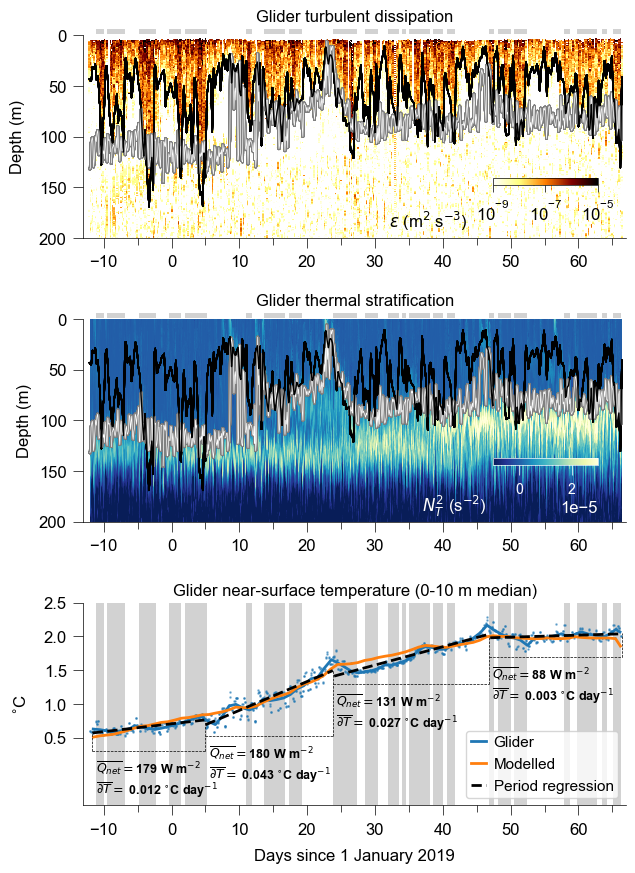

In [47]:
fig,ax=plt.subplots(3, figsize=(7,10))

fig.subplots_adjust(hspace=0.4)

img_ep = ax[0].pcolormesh(ep.DOY, ep.DEPTH, ep.EPS_FINAL, norm=LogNorm(vmin=10e-10, vmax=10e-6), cmap='afmhot_r', shading='auto')

caxis = fig.add_axes([0.71, 0.73, 0.15, 0.0075])
cb = fig.colorbar(mappable=img_ep, cax=caxis, orientation='horizontal')
cb.outline.set_edgecolor('k')  # Color of colorbar box
cb.ax.xaxis.set_tick_params(color='k', labelcolor='k', labelsize=12, length=5)  # Color of ticks

img_st = ax[1].pcolormesh(sl_grid.DOY, sl_grid.depth, sl_grid.N2_T_rm.interpolate_na(dim='time'), vmin=-1e-5, vmax=3e-5, cmap='YlGnBu_r')

caxis = fig.add_axes([0.71, 0.45, 0.15, 0.0075])
cb = fig.colorbar(mappable=img_st, cax=caxis, orientation='horizontal')
cb.outline.set_edgecolor('white')  # Color of colorbar box
cb.ax.xaxis.set_tick_params(color='white', labelcolor='white', labelsize=10)  # Color of ticks

# Change colorbar tick length
# cb.ax.tick_params(length=0)

#dpt = 100

#ax[1].plot(sl_grid.DOY, N2_rm,   lw=1, c='k', label='$N^2$')
#ax[1].plot(sl_grid.DOY, N2_S_rm, lw=1, c='tab:blue', label='$N_S^2$')
#ax[1].plot(sl_grid.DOY, N2_T_rm, lw=1, c='tab:red', label='$N_T^2$')

#ax[1].legend(ncol=3, loc=2, bbox_to_anchor=(0.0, 1.0), handlelength=1, handletextpad=0.5, borderpad=0.3, fontsize=11, frameon=True)

#ax[1].fill_between(x=sl_grid.DOY, y1=N2_rm   - N2_series_std  , y2=N2_rm   + N2_series_std  , alpha=0.15, facecolor='k')
#ax[1].fill_between(x=sl_grid.DOY, y1=N2_S_rm - N2_S_series_std, y2=N2_S_rm + N2_S_series_std, alpha=0.15, facecolor='tab:blue')
#ax[1].fill_between(x=sl_grid.DOY, y1=N2_T_rm - N2_T_series_std, y2=N2_T_rm + N2_T_series_std, alpha=0.15, facecolor='tab:red')

ax[2].plot(sl_sst_1d.DOY, sl_sst_1d.sst, c='tab:blue', lw=2, label='Glider')

ax[2].scatter(sl_sst.DOY, sl_sst.sst, s=3, marker='.', alpha=0.5)

# plot the projected sst

ax[2].plot(ds_era5_site_1D.DOY, ds_era5_site_1D.proj_sst_net+0.5, label='Modelled', c='tab:orange', lw=2)

for i, a in enumerate(ax):
    
    a.set_xlim(-13, 67)
    a.xaxis.set_ticks(np.arange(-10, 70, 10), minor=False)
    a.xaxis.set_ticks(np.arange(-10, 70, 5), minor=True)

    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

    for s in range(len(merged_storms)):
        
        start = merged_storms[s][0]
        end = merged_storms[s][-1]

        if i==2:
            a.fill_betweenx(y=[-200, 1000], x1=ds_era5_site.DOY[start], x2=ds_era5_site.DOY[end], facecolor='0.65', alpha=0.5, zorder=0)
        else:
            a.fill_betweenx(y=[-6, -1], x1=ds_era5_site.DOY[start], x2=ds_era5_site.DOY[end], facecolor='0.65', alpha=0.5, zorder=0, clip_on=False)     
            a.plot(sl_grid.DOY, sl_grid.mld_t-10, c='0.5', lw=2, ls='-')
            a.plot(sl_grid.DOY, sl_grid.mld_t-10, c='w', lw=0.5, ls='-')
            a.plot(xld.DOY, xld.xld, c='k', lw=1)  
            a.set_ylim(200, 0)  

ax[0].set_ylabel('Depth (m)', labelpad=10)
# ax[1].set_ylabel('s$^{-2}$', labelpad=5)
ax[1].set_ylabel('Depth (m)', labelpad=5)
ax[2].set_ylabel('$^{\circ}$C', labelpad=10)

ax[2].set_ylim(-0.5, 2.5)
ax[2].yaxis.set_ticks(np.arange(0.5, 3, 0.5))

ax[2].set_xlabel('Days since 1 January 2019', labelpad=8)

x1 = -11.7
x2 = 5
x3 = 23.8
x4 = 46.8
x5 = 66.5

y1 = 0.3
y2 = 0.525 
y3 = 1.3
y4 = 1.7

ax[2].plot([x1, x2], [y1, y1], c='k', lw=0.5, ls='--')
ax[2].plot([x2, x3], [y2, y2], c='k', lw=0.5, ls='--')
ax[2].plot([x3, x4], [y3, y3], c='k', lw=0.5, ls='--')
ax[2].plot([x4, x5], [y4, y4], c='k', lw=0.5, ls='--')

x = sl_sst.DOY
y = sl_sst.sst

plot_reg(x,y,x1,x2,ax[2], color='k')
plot_reg(x,y,x2,x3,ax[2], color='k')
plot_reg(x,y,x3,x4,ax[2], color='k')
plot_reg(x,y,x4,x5,ax[2], color='k', label=True)

x = ds_era5_site.DOY
y = ds_era5_site['proj_sst_net'] + 0.6

#plot_reg(x,y,x1,x2,ax[2], color='tab:orange')
#plot_reg(x,y,x2,x3,ax[2], color='tab:orange')
#plot_reg(x,y,x3,x4,ax[2], color='tab:orange')
#plot_reg(x,y,x4,x5,ax[2], color='tab:orange')

# legend

ax[2].legend(ncol=1, loc=4, bbox_to_anchor=(1.0, 0.0), handlelength=1, handletextpad=0.5, borderpad=0.3, fontsize=11, frameon=True)

props = dict(fontsize=9, fontweight='bold')

y_offset = 0.32
x_offset = 0.5

q_mean = np.round(ds_era5_site.isel(time=((ds_era5_site.DOY > x1) & (ds_era5_site.DOY < x2))).qnet.mean(dim='time').data)
ax[2].text(x1 + x_offset, y1 - y_offset, r'$\overline{Q_{net}} = $' + str(q_mean.astype(int)) + ' W m$^{-2}$', **props)

q_mean = np.round(ds_era5_site.isel(time=((ds_era5_site.DOY > x2) & (ds_era5_site.DOY < x3))).qnet.mean(dim='time').data)
ax[2].text(x2 + x_offset, y2 - y_offset, r'$\overline{Q_{net}} = $' + str(q_mean.astype(int)) + ' W m$^{-2}$', **props)

q_mean = np.round(ds_era5_site.isel(time=((ds_era5_site.DOY > x3) & (ds_era5_site.DOY < x4))).qnet.mean(dim='time').data)
ax[2].text(x3 + x_offset, y3 - y_offset, r'$\overline{Q_{net}} = $' + str(q_mean.astype(int)) + ' W m$^{-2}$', **props)

q_mean = np.round(ds_era5_site.isel(time=((ds_era5_site.DOY > x4) & (ds_era5_site.DOY < x5))).qnet.mean(dim='time').data)
ax[2].text(x4 + x_offset, y4 - y_offset, r'$\overline{Q_{net}} = $' + str(q_mean.astype(int)) + ' W m$^{-2}$', **props)

# mean warming rate

dt_mean = np.round(sl_sst_1d.isel(time=((sl_sst_1d.DOY > x1) & (sl_sst_1d.DOY < x2))).sst.diff(dim='time').mean(dim='time').data, 3)
# ax[2].text(x1 + x_offset, y1 + y_offset, r'$\overline{\partial T} = $' + str(dt_mean) + ' $^{\circ}$C day$^{-1}$', **props)
ax[2].text(x1 + x_offset, y1 - y_offset-0.32, r'$\overline{\partial T} = $ 0.012 $^{\circ}$C day$^{-1}$', **props)

dt_mean = np.round(sl_sst_1d.isel(time=((sl_sst_1d.DOY > x2) & (sl_sst_1d.DOY < x3))).sst.diff(dim='time').mean(dim='time').data, 3)
ax[2].text(x2 + x_offset, y2 - y_offset-0.32, r'$\overline{\partial T} = $ 0.043 $^{\circ}$C day$^{-1}$', **props)

dt_mean = np.round(sl_sst_1d.isel(time=((sl_sst_1d.DOY > x3) & (sl_sst_1d.DOY < x4))).sst.diff(dim='time').mean(dim='time').data, 3)
ax[2].text(x3 + x_offset, y3 - y_offset-0.32, r'$\overline{\partial T} = $ 0.027 $^{\circ}$C day$^{-1}$', **props)

dt_mean = np.round(sl_sst_1d.isel(time=((sl_sst_1d.DOY > x4) & (sl_sst_1d.DOY < x5))).sst.diff(dim='time').mean(dim='time').data, 3)
ax[2].text(x4 + x_offset, y4 - y_offset-0.32, r'$\overline{\partial T} = $ 0.003 $^{\circ}$C day$^{-1}$', **props)

# fig.tight_layout()

# bbox_props = dict(boxstyle="round,pad=0.3", fc="0.95", ec="black", lw=1)

# ax[0].text(15, 182, 'Temperature stratification', ha="center", va="center", bbox=bbox_props)
# ax[1].text(25, 1.3e-5, 'Stratification 0-100 m', ha="center", va="center", bbox=bbox_props)
# ax[2].text(25, 0.5, '10m glider temperature', ha="center", va="center", bbox=bbox_props)

ax[0].set_title('Glider turbulent dissipation', fontsize=12, pad=10)
ax[1].set_title('Glider thermal stratification', fontsize=12, pad=10)
ax[2].set_title('Glider near-surface temperature (0-10 m median)', fontsize=12, pad=5)

ax[0].text(32, 190, '$\epsilon$ (m$^2$ s$^{-3}$)')
ax[1].text(37, 190, '$N_T^2$ (s$^{-2}$)', c='white')

ax[2].plot([x1, x1], [y1, 0.60], c='k', lw=0.5, ls='--')
ax[2].plot([x2, x2], [y1, 0.75], c='k', lw=0.5, ls='--')
ax[2].plot([x3, x3], [y2, 1.49], c='k', lw=0.5, ls='--')
ax[2].plot([x4, x4], [y3, 2.00], c='k', lw=0.5, ls='--')
ax[2].plot([x5, x5], [y4, 2.05], c='k', lw=0.5, ls='--')

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/figure2_N2_sst.png', dpi=300)

In [35]:
plot_reg(x,y,x1,x2,ax[2], color='tab:orange')
plot_reg(x,y,x2,x3,ax[2], color='tab:orange')
plot_reg(x,y,x3,x4,ax[2], color='tab:orange')
plot_reg(x,y,x4,x5,ax[2], color='tab:orange')

R-squared: 0.988840Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.

degC/day: 0.021426983269126402
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
R-squared: 0.954093
degC/day: 0.03535068289292798
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.R-squared: 0.957881
degC/day: 0.01769079388064605

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only

In [36]:
# mean and standard deviations of the mld

x1 = -11.7
x2 = 5
x3 = 23.8
x4 = 46.8
x5 = 66.5

idx = ((sl_grid.DOY>x2) & (sl_grid.DOY<x3))

print('mean mld:', sl_grid.isel(time=idx).mld_t.mean().values)
print('std mld:', sl_grid.isel(time=idx).mld_t.std().values)

mean mld: 92.94708994708995
std mld: 30.8565095993258


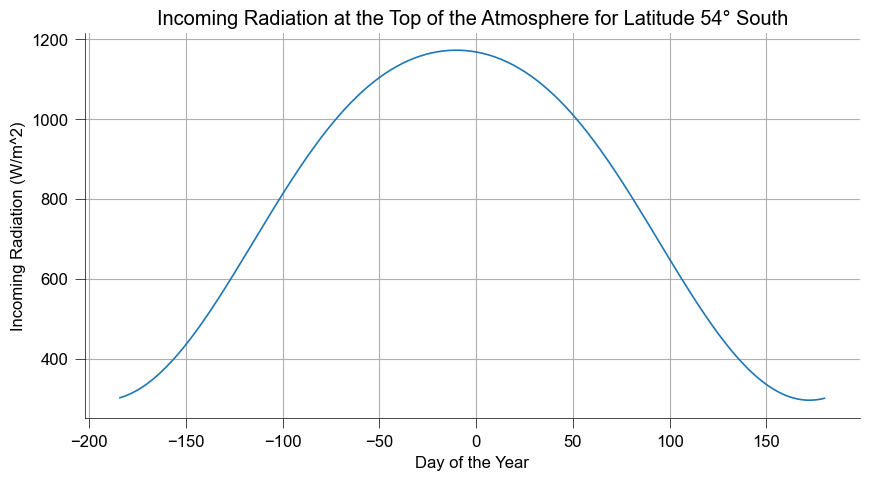

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Define the solar constant (in W/m^2)
solar_constant = 1361

# Define the latitude (in degrees)
latitude_deg = -54  # Negative for southern hemisphere

# Convert the latitude to radians
latitude_rad = np.radians(latitude_deg)

# Create an array for the day of the year
day_of_year = np.arange(1, 366)

# Calculate the declination angle (in degrees)
declination_angle_deg = 23.45 * np.sin((2 * np.pi / 365.0) * (day_of_year - 81))

# Convert the declination angle to radians
declination_angle_rad = np.radians(declination_angle_deg)

# Calculate the solar elevation angle at solar noon (in radians)
solar_elevation_angle_rad = np.arcsin(np.sin(latitude_rad) * np.sin(declination_angle_rad) + np.cos(latitude_rad) * np.cos(declination_angle_rad))

# Calculate the incoming radiation at the top of the atmosphere (in W/m^2)
incoming_radiation = solar_constant * np.sin(solar_elevation_angle_rad)

# sort it so that it fits the date format
day_of_year[day_of_year>180] = day_of_year[day_of_year>180] - 365
idx = np.argsort(day_of_year)

day_of_year = day_of_year[idx]
incoming_radiation = incoming_radiation[idx]

# Plot the incoming radiation as a function of day of the year
plt.figure(figsize=(10, 5))
plt.plot(day_of_year, incoming_radiation)
plt.xlabel('Day of the Year')
plt.ylabel('Incoming Radiation (W/m^2)')
plt.title('Incoming Radiation at the Top of the Atmosphere for Latitude 54° South')
plt.grid(True)
plt.show()


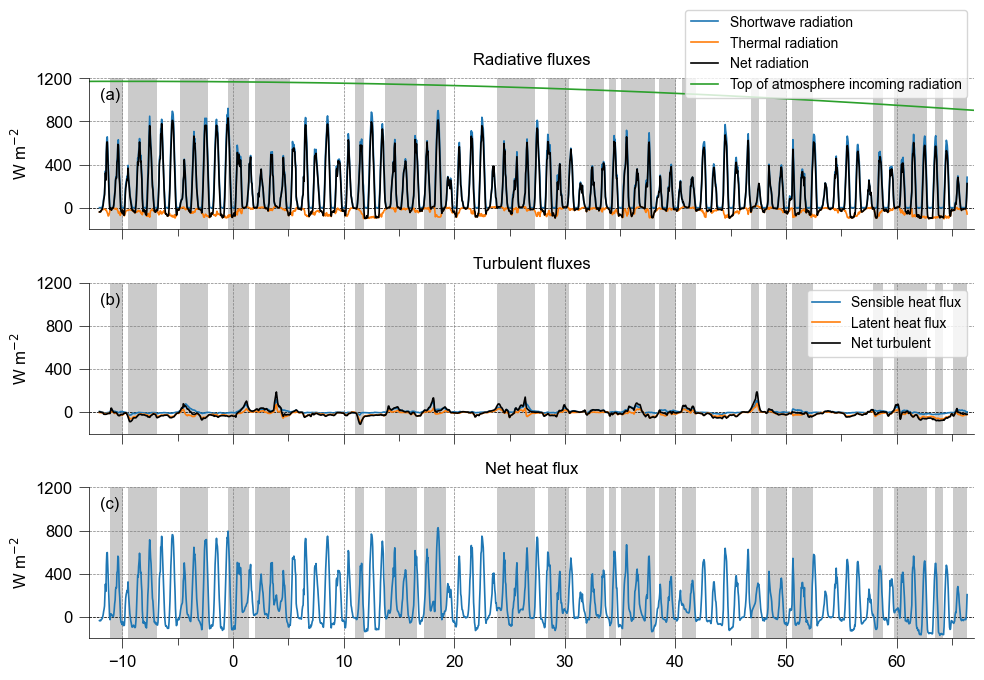

In [38]:
# plot the heat flux time series

fig, ax = plt.subplots(3, figsize=(10,7), sharex=True)

for a in ax:
    a.axhline(c='k', lw=0.5, ls='--')
    a.grid(lw=0.5, c='0.5', ls='--')
    a.set_ylabel('W m$^{-2}$')

ax[0].plot(ds_era5_site.DOY, ds_era5_site.ssr, label='Shortwave radiation')
ax[0].plot(ds_era5_site.DOY, ds_era5_site.str, label='Thermal radiation')
ax[0].plot(ds_era5_site.DOY, ds_era5_site.str+ds_era5_site.ssr, label='Net radiation', c='k')
ax[0].plot(day_of_year, incoming_radiation, label='Top of atmosphere incoming radiation')

ax[0].legend(bbox_to_anchor=(1.0, 1.5), loc=1, fontsize=10)

ax[1].plot(ds_era5_site.DOY, ds_era5_site.sshf, label='Sensible heat flux')
ax[1].plot(ds_era5_site.DOY, ds_era5_site.slhf, label='Latent heat flux')
ax[1].plot(ds_era5_site.DOY, ds_era5_site.sshf+ds_era5_site.slhf, label='Net turbulent', c='k')

ax[1].legend(fontsize=10)

ax[2].plot(ds_era5_site.DOY, ds_era5_site.qnet)

ax[0].set_ylim(-200, 1200)
ax[1].set_ylim(-200, 1200)
ax[2].set_ylim(-200, 1200)

ax[0].set_title('Radiative fluxes', fontsize=12, pad=10)
ax[1].set_title('Turbulent fluxes', fontsize=12, pad=10)
ax[2].set_title('Net heat flux', fontsize=12, pad=10)

for i, a in enumerate(ax):
    
    a.set_xlim(-13, 67)
    a.xaxis.set_ticks(np.arange(-10, 70, 10), minor=False)
    a.xaxis.set_ticks(np.arange(-10, 70, 5), minor=True)

    a.yaxis.set_ticks(np.arange(0, 1600, 400))

    a.spines['right'].set_visible(False)
    a.spines['top'].set_visible(False)

    for s in range(len(merged_storms)):
        
        start = merged_storms[s][0]
        end = merged_storms[s][-1]

        a.fill_betweenx(y=[-200, 1200], x1=ds_era5_site.DOY[start], x2=ds_era5_site.DOY[end], facecolor='0.6', alpha=0.5, zorder=0)

ax[0].text(-12, 1000, '(a)')
ax[1].text(-12, 1000, '(b)')
ax[2].text(-12, 1000, '(c)')

fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/heat_fluxes.png', dpi=600)

R-squared: 0.495958Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



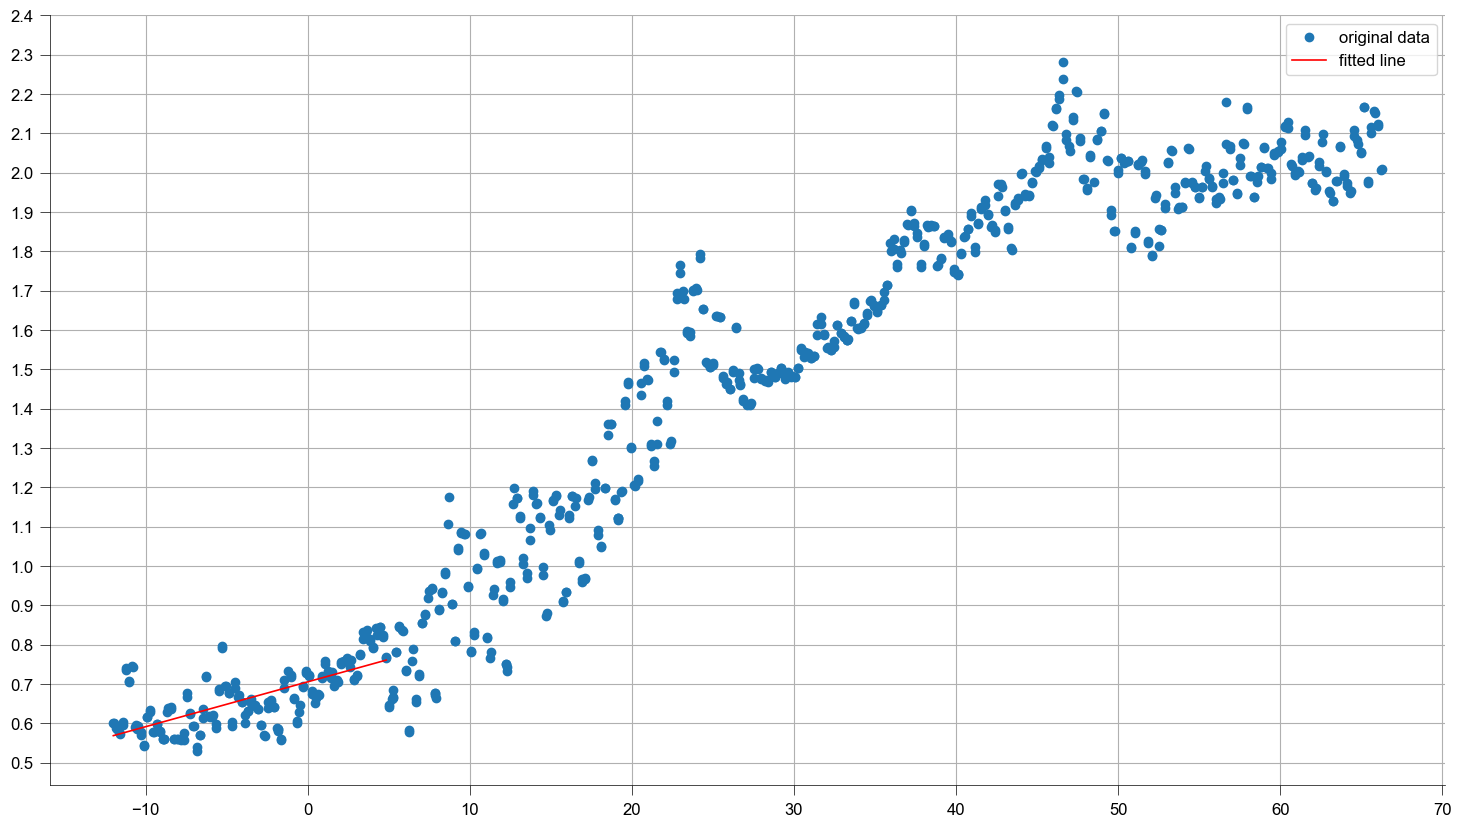

In [39]:
from scipy import stats

# Your data
x = sl_sst.DOY
y = sl_sst.sst

idx = (sl_sst.DOY > -12) & (sl_sst.DOY < 5)

x_subset = sl_sst.DOY.isel(time=idx)
y_subset = sl_sst.sst.isel(time=idx)

# Create a linear regression model
res = stats.linregress(x_subset, y_subset)

print(f"R-squared: {res.rvalue**2:.6f}")

fig, ax = plt.subplots()

ax.plot(x, y, 'o', label='original data')
ax.plot(x_subset, res.intercept + res.slope*x_subset, 'r', label='fitted line')

ax.legend()
ax.grid()

ax.yaxis.set_ticks(np.arange(0.5, 2.5, 0.1))


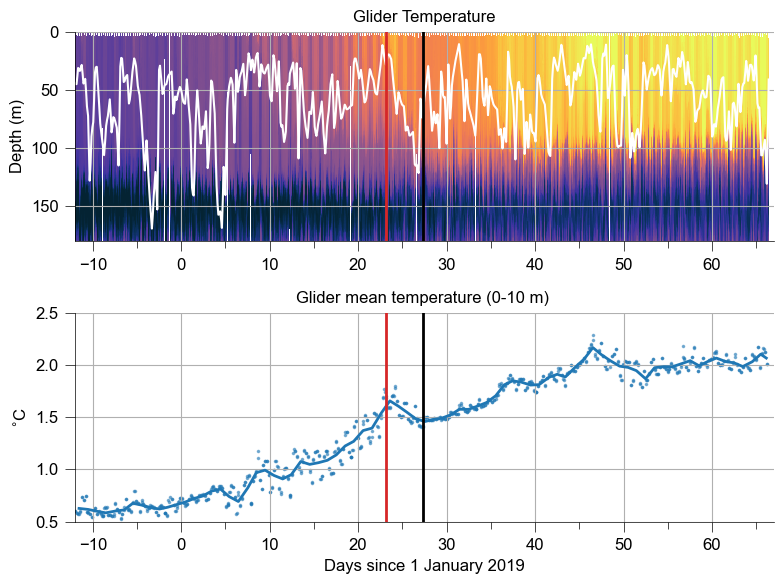

In [40]:
fig,ax = plt.subplots(2, figsize=(8,6))

ax[0].pcolormesh(sl_grid.DOY, sl_grid.depth, sl_grid.temperature, cmap=cmo.thermal, vmin=0, vmax=2.1)
ax[0].set_ylim(180, 0)
ax[0].plot(xld.DOY, xld.xld, c='w', lw=1.5)

ax[1].plot(sl_sst_1d.DOY, sl_sst_1d.sst, c='tab:blue', lw=2, label='Glider')
ax[1].scatter(sl_sst.DOY, sl_sst.sst, s=10, marker='.', alpha=0.5)

for a in ax:
    a.grid()
    a.set_xlim(-12, 67)
    a.xaxis.set_ticks(np.arange(-10, 70, 10), minor=False)
    a.xaxis.set_ticks(np.arange(-10, 70, 5), minor=True)

ax[1].set_ylim(0.5, 2.5)

doy=[23.2,27.3]

for a in ax:
    a.axvline(doy[0], c='tab:red', lw=2)
    a.axvline(doy[1], c='k', lw=2)

ax[0].set_ylabel('Depth (m)')
ax[1].set_ylabel('$^{\circ}$C')

ax[0].set_title('Glider Temperature', fontsize=12, pad=7)
ax[1].set_title('Glider mean temperature (0-10 m) ', fontsize=12, pad=7)

ax[1].set_xlabel('Days since 1 January 2019')

fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/entrainment_section_example.png', dpi=600)

In [41]:
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True

mean temp before:  0.9831140518288258
mean temp after:  1.0155893147124282


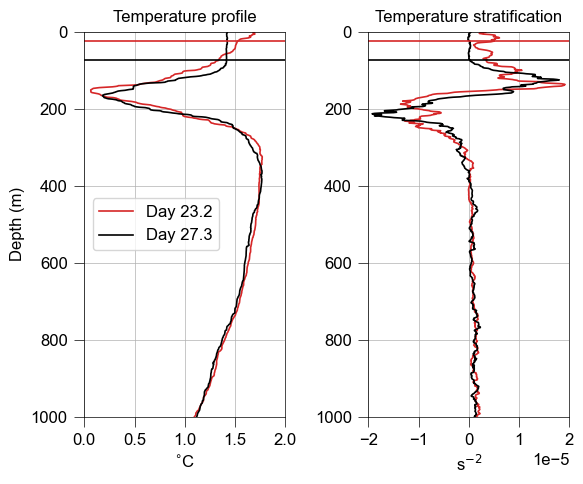

In [91]:
doy=[23.2,27.3]

fig,ax=plt.subplots(1,2,figsize=(6, 5))

before_i = np.argmin(np.abs(sl_grid.DOY.values-doy[0]))
after_i = np.argmin(np.abs(sl_grid.DOY.values-doy[1]))

ax[0].plot(sl_grid.isel(time=before_i).temperature, sl_grid.depth, c='tab:red', label='Day 23.2')
ax[0].plot(sl_grid.isel(time=after_i).temperature, sl_grid.depth, c='k', label='Day 27.3')

ax[0].legend()

ax[1].plot(sl_grid.isel(time=before_i).N2_T_rm, sl_grid.depth, c='tab:red')
ax[1].plot(sl_grid.isel(time=after_i).N2_T_rm, sl_grid.depth, c='k')

print('mean temp before: ', sl_grid.isel(time=before_i).temperature.sel(depth=slice(0,200)).mean().values)
print('mean temp after: ', sl_grid.isel(time=after_i).temperature.sel(depth=slice(0,200)).mean().values)

before_i_xld = np.argmin(np.abs(xld.DOY.values-doy[0]))
after_i_xld = np.argmin(np.abs(xld.DOY.values-doy[1]))

for a in ax:
    a.invert_yaxis()
    a.set_ylim(1000, 0)
    a.axhline(xld.isel(time=before_i_xld).xld, c='tab:red')
    a.axhline(xld.isel(time=after_i_xld).xld, c='k')
    a.grid(lw=0.5)

fig.tight_layout()

import gsw

lat_before = sl_grid.isel(time=before_i).latitude
lon_before = sl_grid.isel(time=before_i).longitude

lat_after = sl_grid.isel(time=after_i).latitude
lon_after = sl_grid.isel(time=after_i).longitude

gsw.distance([lon_before, lon_after], [lat_before, lat_after])

ax[0].set_xlim(0, 2)
ax[1].set_xlim(-2e-5, 2e-5)

ax[0].set_title('Temperature profile', fontsize=12, pad=7)
ax[1].set_title('Temperature stratification', fontsize=12, pad=7)

ax[0].set_ylabel('Depth (m)')

ax[0].set_xlabel('$^{\circ}$C')
ax[1].set_xlabel('s$^{-2}$')

fig.tight_layout()

plt.savefig('/Users/xduplm/Google Drive/My Drive/projects/2023_duplessis_storms_fluxes/figs/entrainment_profile_example.png', dpi=600)



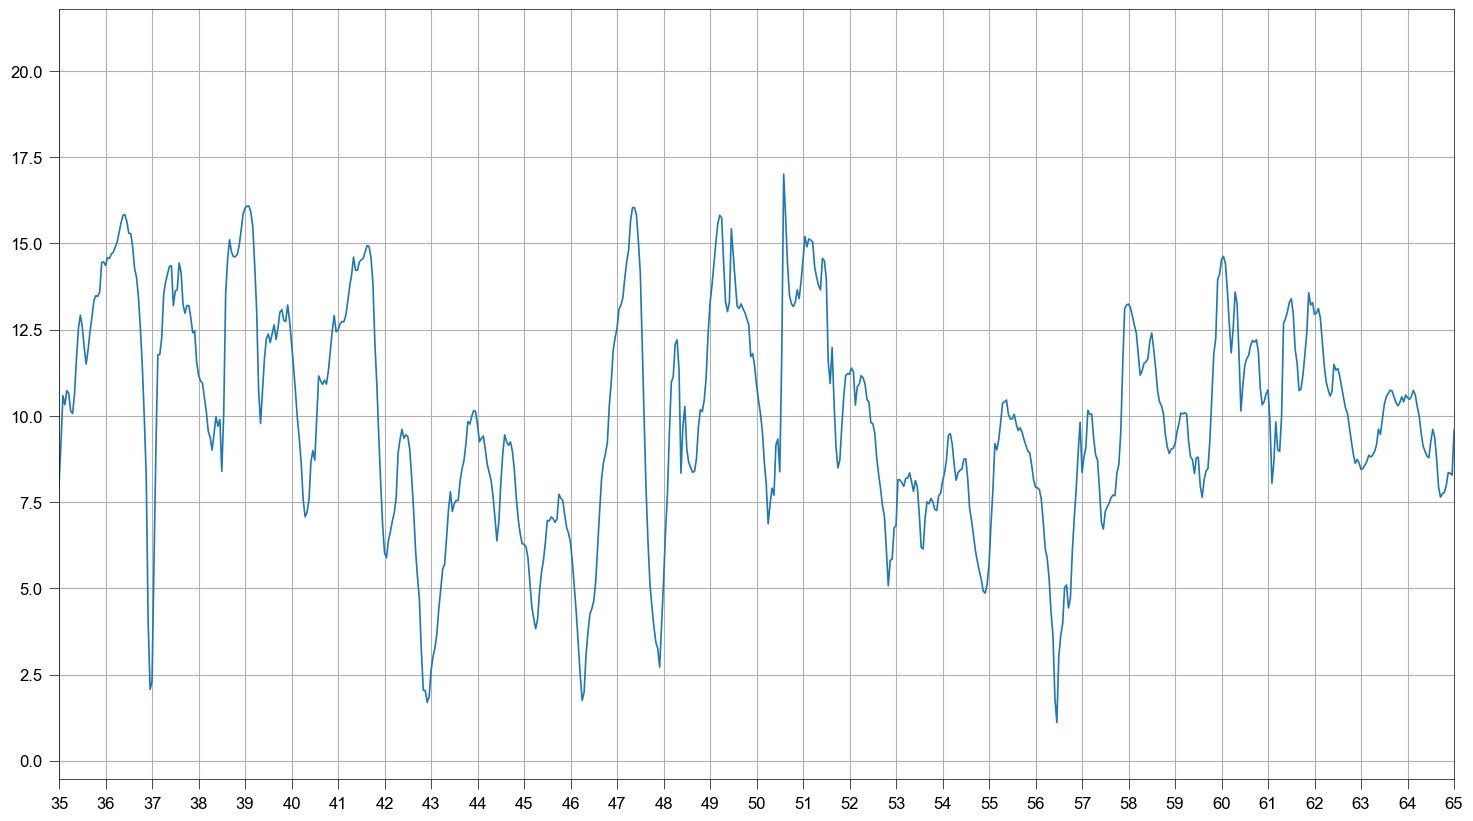

In [104]:
fig, ax = plt.subplots()

ax.plot(ds_era5_site.DOY, ds_era5_site.wnd)
ax.xaxis.set_ticks(np.arange(-12, 68, 1))

ax.set_xlim(35, 65)

ax.grid()


In [ ]:
sl_grid.latitude

<xarray.DataArray 'latitude' (latitude: 910)>
array([-54.003992, -53.991808, -53.984639, ..., -54.010868, -54.01061 ,
       -54.010386])
Coordinates:
  * latitude  (latitude) float64 -54.0 -53.99 -53.98 ... -54.01 -54.01 -54.01

In [40]:
sl_grid.isel(time=after_i)

NameError: name 'after_i' is not defined

In [ ]:
gsw.distance([lon_before, lon_after], [lat_before, lat_after])

array([0.])